# Semesterarbeit Teil 3

### Teil 3

### Einführung
Es sollen hier ein paar Spark Structured Streamings angesehen werden. Ein zweites Jupyter Notebook enthält die Inhalte von generator.py.
Die generierten Zeilen, die den Events entsprechen, sehen so aus:

sending: msg_enq,0,1,43,enrol_req,-1,1747298059.982384,14,1747298067.551609<br>
sending: msg_enq,0,1,43,enrol_req,-1,1747298059.982384,14,1747298067.551609<br>
sending: msg_deq,0,1,0,enrol_req,-1,1747298059.982384,10,1747298067.652745<br>
sending: ta_exec,0,1,0,enrol_req,-1,1747298060.042384,10,1747298067.753717<br>

Es gibt zwei Jupyter Notebooks, die zur Anwendung kommen:

- Dieses Jupyter Notebook enthält: Lesen, Operation, Schreiben, Output. Ich nenne es Receiver.

- Das zweite Jupyter Notebook enthält: Generator.py. Ich nenne es Generator.

Es soll mit sleep(0.001), sleep(0.01), sleep(0.1) und sleep(1) die Unterschiede beobachtet werden. Zum einen werden seitens Generator die 60 Sekunden gezählt und zum anderen sollem hier die 60 Skunden am Query selbst gezählt werden, dies mit query1.awaitTermination(60)

### generator.py
Es gibt zwei Versionen davon, in zwei Zellen. Die erste Zelle enthält undverändert den Code, abgesehen von der Ausgabe von count.<br>
Die zweite Zelle enthält einen Zähler von 60 Sekunden und der Ausgabe von count. Die Zelle endet also nach 60 Sekunden.<br>

Hier nur ein Ausschnitt davon:

        for line in lines:
            if time() - start_time >= 60:
                break  # Exit if 60 seconds is reached

            line[6] = str(float(line[6]) / 1000 + DIFF_TIMESTAMP)
            line.append(str(datetime.now().timestamp()))
            joinedLine = ','.join(line) + '\n'
            print('sending: ' + joinedLine)
            c.send(joinedLine.encode('utf-8'))
            sleep(1)
            print(count)
            count += 1

        c.close()
        print("sended items: " + str(count))

Import und Session Builder

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import split, col, window, to_timestamp, from_unixtime
from pyspark.sql.functions import window
import time

# SparkSession erstellen
spark = SparkSession.builder \
    .appName("Realtime CSV Streaming") \
    .master("spark://localhost:7077") \
    .getOrCreate()

### Teil 1 sleep(0.001)
Mit sleep(0.001) die Event sammeln, dies ist 1 Millisekunde.

Hier also ein Window von einer Minute und ein Watermark von einer Minute. Hier werden die 60 Sekunden seitens diesem Jupyter Notebook gerechnet.

In [2]:
# Lese Daten vom Socket
raw_df = spark.readStream \
    .format("socket") \
    .option("host", "localhost") \
    .option("port", 9999) \
    .load()

spark.conf.set("spark.sql.shuffle.partitions", "4")
spark.conf.set("spark.sql.streaming.microBatchDuration", "200ms")

# Zeile parsen
parsed_df = raw_df.withColumn("csv", split(col("value"), ","))

# Wahl von Code und Timestamp
df = parsed_df.select(
    col("csv").getItem(0).alias("code"),
    from_unixtime(col("csv").getItem(6).cast("double")).cast("timestamp").alias("event_time")
)

# Verwendung von Watermark und Window
events_per_minute = df \
    .withWatermark("event_time", "1 minute") \
    .groupBy(
        window(col("event_time"), "1 minute"),
        col("code")
    ).count()

# Ausgabe
query1 = events_per_minute.writeStream \
    .trigger(processingTime="5 seconds") \
    .outputMode("complete") \
    .format("console") \
    .option("truncate", False) \
    .start()

# Beenden der Ausgabe nach 60 Sekunden
query1.awaitTermination(60)

# Sicherstellen, dass die Query danach sauber beendet wird
if query1.isActive:
    query1.stop()
    print("Stream gestoppt nach 60 Sekunden.")
else:
    print("Stream endete automatisch.")

-------------------------------------------
Batch: 0
-------------------------------------------
+------+----+-----+
|window|code|count|
+------+----+-----+
+------+----+-----+



-------------------------------------------
Batch: 1
-------------------------------------------
+------------------------------------------+-------+-----+
|window                                    |code   |count|
+------------------------------------------+-------+-----+
|{2025-05-17 06:44:00, 2025-05-17 06:45:00}|ta_exec|355  |
|{2025-05-17 06:44:00, 2025-05-17 06:45:00}|msg_enq|358  |
|{2025-05-17 06:44:00, 2025-05-17 06:45:00}|msg_arr|358  |
|{2025-05-17 06:44:00, 2025-05-17 06:45:00}|res_snd|355  |
|{2025-05-17 06:44:00, 2025-05-17 06:45:00}|ts_rcvd|76   |
|{2025-05-17 06:44:00, 2025-05-17 06:45:00}|msg_deq|356  |
+------------------------------------------+-------+-----+



-------------------------------------------
Batch: 2
-------------------------------------------
+------------------------------------------+-------+-----+
|window                                    |code   |count|
+------------------------------------------+-------+-----+
|{2025-05-17 06:44:00, 2025-05-17 06:45:00}|msg_enq|592  |
|{2025-05-17 06:44:00, 2025-05-17 06:45:00}|ta_exec|591  |
|{2025-05-17 06:44:00, 2025-05-17 06:45:00}|msg_arr|592  |
|{2025-05-17 06:44:00, 2025-05-17 06:45:00}|res_snd|590  |
|{2025-05-17 06:44:00, 2025-05-17 06:45:00}|ts_rcvd|130  |
|{2025-05-17 06:44:00, 2025-05-17 06:45:00}|msg_deq|591  |
+------------------------------------------+-------+-----+

-------------------------------------------
Batch: 3
-------------------------------------------
+------------------------------------------+-------+-----+
|window                                    |code   |count|
+------------------------------------------+-------+-----+
|{2025-05-17 06:44:00, 2025-05-17 06:4

Hier also ein Window von einer Minute und ein Watermark von einer Minute. Hier werden nun die 60 Sekunden seitens Generator gerechnet.

In [ ]:
# Lese Daten vom Socket
raw_df = spark.readStream \
    .format("socket") \
    .option("host", "localhost") \
    .option("port", 9999) \
    .load()

spark.conf.set("spark.sql.shuffle.partitions", "4")
spark.conf.set("spark.sql.streaming.microBatchDuration", "200ms")

# Zeile parsen
parsed_df = raw_df.withColumn("csv", split(col("value"), ","))

# Wahl von Code und Timestamp
df = parsed_df.select(
    col("csv").getItem(0).alias("code"),
    from_unixtime(col("csv").getItem(6).cast("double")).cast("timestamp").alias("event_time")
)

# Verwendung von Watermark und Window
events_per_minute = df \
    .withWatermark("event_time", "1 minute") \
    .groupBy(
        window(col("event_time"), "1 minute"),
        col("code")
    ).count()

# Ausgabe
query1 = events_per_minute.writeStream \
    .trigger(processingTime="5 seconds") \
    .outputMode("complete") \
    .format("console") \
    .option("truncate", False) \
    .start()

# Beenden des Query
query1.awaitTermination()

-------------------------------------------
Batch: 0
-------------------------------------------
+------+----+-----+
|window|code|count|
+------+----+-----+
+------+----+-----+



-------------------------------------------
Batch: 1
-------------------------------------------
+------------------------------------------+-------+-----+
|window                                    |code   |count|
+------------------------------------------+-------+-----+
|{2025-05-17 06:48:00, 2025-05-17 06:49:00}|ta_exec|492  |
|{2025-05-17 06:48:00, 2025-05-17 06:49:00}|msg_arr|494  |
|{2025-05-17 06:48:00, 2025-05-17 06:49:00}|res_snd|491  |
|{2025-05-17 06:48:00, 2025-05-17 06:49:00}|msg_deq|492  |
|{2025-05-17 06:48:00, 2025-05-17 06:49:00}|ts_rcvd|107  |
|{2025-05-17 06:48:00, 2025-05-17 06:49:00}|msg_enq|494  |
+------------------------------------------+-------+-----+



-------------------------------------------
Batch: 2
-------------------------------------------
+------------------------------------------+-------+-----+
|window                                    |code   |count|
+------------------------------------------+-------+-----+
|{2025-05-17 06:48:00, 2025-05-17 06:49:00}|ta_exec|820  |
|{2025-05-17 06:48:00, 2025-05-17 06:49:00}|res_snd|820  |
|{2025-05-17 06:48:00, 2025-05-17 06:49:00}|msg_deq|821  |
|{2025-05-17 06:48:00, 2025-05-17 06:49:00}|msg_arr|824  |
|{2025-05-17 06:48:00, 2025-05-17 06:49:00}|ts_rcvd|186  |
|{2025-05-17 06:48:00, 2025-05-17 06:49:00}|msg_enq|824  |
+------------------------------------------+-------+-----+

-------------------------------------------
Batch: 3
-------------------------------------------
+------------------------------------------+-------+-----+
|window                                    |code   |count|
+------------------------------------------+-------+-----+
|{2025-05-17 06:48:00, 2025-05-17 06:4

-------------------------------------------
Batch: 8
-------------------------------------------
+------------------------------------------+-------+-----+
|window                                    |code   |count|
+------------------------------------------+-------+-----+
|{2025-05-17 06:48:00, 2025-05-17 06:49:00}|ta_exec|2977 |
|{2025-05-17 06:48:00, 2025-05-17 06:49:00}|res_snd|2977 |
|{2025-05-17 06:48:00, 2025-05-17 06:49:00}|msg_deq|2977 |
|{2025-05-17 06:48:00, 2025-05-17 06:49:00}|msg_arr|2986 |
|{2025-05-17 06:48:00, 2025-05-17 06:49:00}|ts_rcvd|707  |
|{2025-05-17 06:48:00, 2025-05-17 06:49:00}|msg_enq|2986 |
+------------------------------------------+-------+-----+



-------------------------------------------
Batch: 9
-------------------------------------------
+------------------------------------------+-------+-----+
|window                                    |code   |count|
+------------------------------------------+-------+-----+
|{2025-05-17 06:48:00, 2025-05-17 06:49:00}|ta_exec|3338 |
|{2025-05-17 06:48:00, 2025-05-17 06:49:00}|res_snd|3338 |
|{2025-05-17 06:48:00, 2025-05-17 06:49:00}|msg_deq|3338 |
|{2025-05-17 06:48:00, 2025-05-17 06:49:00}|msg_arr|3346 |
|{2025-05-17 06:48:00, 2025-05-17 06:49:00}|ts_rcvd|794  |
|{2025-05-17 06:48:00, 2025-05-17 06:49:00}|msg_enq|3346 |
+------------------------------------------+-------+-----+

-------------------------------------------
Batch: 10
-------------------------------------------
+------------------------------------------+-------+-----+
|window                                    |code   |count|
+------------------------------------------+-------+-----+
|{2025-05-17 06:48:00, 2025-05-17 06:

-------------------------------------------
Batch: 11
-------------------------------------------
+------------------------------------------+-------+-----+
|window                                    |code   |count|
+------------------------------------------+-------+-----+
|{2025-05-17 06:48:00, 2025-05-17 06:49:00}|ta_exec|4083 |
|{2025-05-17 06:48:00, 2025-05-17 06:49:00}|res_snd|4083 |
|{2025-05-17 06:48:00, 2025-05-17 06:49:00}|msg_deq|4083 |
|{2025-05-17 06:48:00, 2025-05-17 06:49:00}|msg_arr|4094 |
|{2025-05-17 06:48:00, 2025-05-17 06:49:00}|ts_rcvd|991  |
|{2025-05-17 06:48:00, 2025-05-17 06:49:00}|msg_enq|4094 |
+------------------------------------------+-------+-----+

-------------------------------------------
Batch: 12
-------------------------------------------
+------------------------------------------+-------+-----+
|window                                    |code   |count|
+------------------------------------------+-------+-----+
|{2025-05-17 06:48:00, 2025-05-17 06

### Teil 1 Resultat
Bei dem ersten Fall werden seitens Generator 22202 Events gesendet, seitens Receiver werden 19920 Events erkannt, was dem Total von count entspricht.<br>
Bei dem zweiten Fall werden seitens Generator 22468 Events gesendet, seitens Receiver werden 22468 Events erkannt, was dem Total von count entspricht.

### Teil 1 Fragestellungen
Wie lässt sich erklären, dass mit query1.awaitTermination(60) weniger Events gezählt werden?<br>
Höchstwahrscheinlich weil der der Query dann die Zeit beendet, und es im Stream noch Events gibt, die dann nicht mehr ausgeschrieben werden.

### Teil 2 sleep(0.01)
Mit sleep(0.01) die Event sammeln, dies sind 10 Millisekunden.

Hier also ein Window von einer Minute und ein Watermark von einer Minute. Hier werden die 60 Sekunden seitens diesem Jupyter Notebook gerechnet.

In [2]:
# Lese Daten vom Socket
raw_df = spark.readStream \
    .format("socket") \
    .option("host", "localhost") \
    .option("port", 9999) \
    .load()

spark.conf.set("spark.sql.shuffle.partitions", "4")
spark.conf.set("spark.sql.streaming.microBatchDuration", "200ms")

# Zeile parsen
parsed_df = raw_df.withColumn("csv", split(col("value"), ","))

# Wahl von Code und Timestamp
df = parsed_df.select(
    col("csv").getItem(0).alias("code"),
    from_unixtime(col("csv").getItem(6).cast("double")).cast("timestamp").alias("event_time")
)

# Verwendung von Watermark und Window
events_per_minute = df \
    .withWatermark("event_time", "1 minute") \
    .groupBy(
        window(col("event_time"), "1 minute"),
        col("code")
    ).count()

# Ausgabe
query1 = events_per_minute.writeStream \
    .trigger(processingTime="5 seconds") \
    .outputMode("complete") \
    .format("console") \
    .option("truncate", False) \
    .start()

# Beenden der Ausgabe nach 60 Sekunden
query1.awaitTermination(60)

# Sicherstellen, dass die Query danach sauber beendet wird
if query1.isActive:
    query1.stop()
    print("Stream gestoppt nach 60 Sekunden.")
else:
    print("Stream endete automatisch.")

-------------------------------------------
Batch: 0
-------------------------------------------
+------+----+-----+
|window|code|count|
+------+----+-----+
+------+----+-----+



-------------------------------------------
Batch: 1
-------------------------------------------
+------------------------------------------+-------+-----+
|window                                    |code   |count|
+------------------------------------------+-------+-----+
|{2025-05-17 07:04:00, 2025-05-17 07:05:00}|msg_arr|85   |
|{2025-05-17 07:04:00, 2025-05-17 07:05:00}|msg_enq|85   |
|{2025-05-17 07:04:00, 2025-05-17 07:05:00}|ta_exec|85   |
|{2025-05-17 07:04:00, 2025-05-17 07:05:00}|res_snd|85   |
|{2025-05-17 07:04:00, 2025-05-17 07:05:00}|msg_deq|85   |
|{2025-05-17 07:04:00, 2025-05-17 07:05:00}|ts_rcvd|15   |
+------------------------------------------+-------+-----+



-------------------------------------------
Batch: 2
-------------------------------------------
+------------------------------------------+-------+-----+
|window                                    |code   |count|
+------------------------------------------+-------+-----+
|{2025-05-17 07:04:00, 2025-05-17 07:05:00}|msg_arr|136  |
|{2025-05-17 07:04:00, 2025-05-17 07:05:00}|msg_enq|136  |
|{2025-05-17 07:04:00, 2025-05-17 07:05:00}|ta_exec|135  |
|{2025-05-17 07:04:00, 2025-05-17 07:05:00}|res_snd|135  |
|{2025-05-17 07:04:00, 2025-05-17 07:05:00}|msg_deq|135  |
|{2025-05-17 07:04:00, 2025-05-17 07:05:00}|ts_rcvd|27   |
+------------------------------------------+-------+-----+



-------------------------------------------
Batch: 3
-------------------------------------------
+------------------------------------------+-------+-----+
|window                                    |code   |count|
+------------------------------------------+-------+-----+
|{2025-05-17 07:04:00, 2025-05-17 07:05:00}|msg_arr|207  |
|{2025-05-17 07:04:00, 2025-05-17 07:05:00}|msg_enq|207  |
|{2025-05-17 07:04:00, 2025-05-17 07:05:00}|ta_exec|207  |
|{2025-05-17 07:04:00, 2025-05-17 07:05:00}|res_snd|207  |
|{2025-05-17 07:04:00, 2025-05-17 07:05:00}|msg_deq|207  |
|{2025-05-17 07:04:00, 2025-05-17 07:05:00}|ts_rcvd|40   |
+------------------------------------------+-------+-----+

-------------------------------------------
Batch: 4
-------------------------------------------
+------------------------------------------+-------+-----+
|window                                    |code   |count|
+------------------------------------------+-------+-----+
|{2025-05-17 07:04:00, 2025-05-17 07:0

Hier also ein Window von einer Minute und ein Watermark von einer Minute. Hier werden nun die 60 Sekunden seitens Generator gerechnet.

In [ ]:
# Lese Daten vom Socket
raw_df = spark.readStream \
    .format("socket") \
    .option("host", "localhost") \
    .option("port", 9999) \
    .load()

spark.conf.set("spark.sql.shuffle.partitions", "4")
spark.conf.set("spark.sql.streaming.microBatchDuration", "200ms")

# Zeile parsen
parsed_df = raw_df.withColumn("csv", split(col("value"), ","))

# Wahl von Code und Timestamp
df = parsed_df.select(
    col("csv").getItem(0).alias("code"),
    from_unixtime(col("csv").getItem(6).cast("double")).cast("timestamp").alias("event_time")
)

# Verwendung von Watermark und Window
events_per_minute = df \
    .withWatermark("event_time", "1 minute") \
    .groupBy(
        window(col("event_time"), "1 minute"),
        col("code")
    ).count()

# Ausgabe
query1 = events_per_minute.writeStream \
    .trigger(processingTime="5 seconds") \
    .outputMode("complete") \
    .format("console") \
    .option("truncate", False) \
    .start()

# Beenden der Ausgabe nach 60 Sekunden
query1.awaitTermination()

-------------------------------------------
Batch: 0
-------------------------------------------
+------+----+-----+
|window|code|count|
+------+----+-----+
+------+----+-----+



-------------------------------------------
Batch: 1
-------------------------------------------
+------------------------------------------+-------+-----+
|window                                    |code   |count|
+------------------------------------------+-------+-----+
|{2025-05-17 07:14:00, 2025-05-17 07:15:00}|msg_arr|86   |
|{2025-05-17 07:14:00, 2025-05-17 07:15:00}|msg_enq|86   |
|{2025-05-17 07:14:00, 2025-05-17 07:15:00}|ts_rcvd|15   |
|{2025-05-17 07:14:00, 2025-05-17 07:15:00}|msg_deq|86   |
|{2025-05-17 07:14:00, 2025-05-17 07:15:00}|res_snd|85   |
|{2025-05-17 07:14:00, 2025-05-17 07:15:00}|ta_exec|85   |
+------------------------------------------+-------+-----+



-------------------------------------------
Batch: 2
-------------------------------------------
+------------------------------------------+-------+-----+
|window                                    |code   |count|
+------------------------------------------+-------+-----+
|{2025-05-17 07:14:00, 2025-05-17 07:15:00}|msg_enq|115  |
|{2025-05-17 07:15:00, 2025-05-17 07:16:00}|res_snd|28   |
|{2025-05-17 07:14:00, 2025-05-17 07:15:00}|msg_arr|115  |
|{2025-05-17 07:15:00, 2025-05-17 07:16:00}|ta_exec|29   |
|{2025-05-17 07:14:00, 2025-05-17 07:15:00}|ts_rcvd|19   |
|{2025-05-17 07:14:00, 2025-05-17 07:15:00}|msg_deq|115  |
|{2025-05-17 07:15:00, 2025-05-17 07:16:00}|msg_deq|28   |
|{2025-05-17 07:14:00, 2025-05-17 07:15:00}|res_snd|114  |
|{2025-05-17 07:15:00, 2025-05-17 07:16:00}|ts_rcvd|9    |
|{2025-05-17 07:14:00, 2025-05-17 07:15:00}|ta_exec|114  |
|{2025-05-17 07:15:00, 2025-05-17 07:16:00}|msg_arr|29   |
|{2025-05-17 07:15:00, 2025-05-17 07:16:00}|msg_enq|29   |
+-----------------

Hier also ein Window von einer Minute und ein Watermark von einer Sekunde. Hier werden nun die 60 Sekunden seitens Generator gerechnet.

In [ ]:
# Lese Daten vom Socket
raw_df = spark.readStream \
    .format("socket") \
    .option("host", "localhost") \
    .option("port", 9999) \
    .load()

spark.conf.set("spark.sql.shuffle.partitions", "4")
spark.conf.set("spark.sql.streaming.microBatchDuration", "200ms")

# Zeile parsen
parsed_df = raw_df.withColumn("csv", split(col("value"), ","))

# Wahl von Code und Timestamp
df = parsed_df.select(
    col("csv").getItem(0).alias("code"),
    from_unixtime(col("csv").getItem(6).cast("double")).cast("timestamp").alias("event_time")
)

# Verwendung von Watermark und Window
events_per_minute = df \
    .withWatermark("event_time", "1 second") \
    .groupBy(
        window(col("event_time"), "1 minute"),
        col("code")
    ).count()

# Ausgabe
query1 = events_per_minute.writeStream \
    .trigger(processingTime="5 seconds") \
    .outputMode("complete") \
    .format("console") \
    .option("truncate", False) \
    .start()

# Beenden der Ausgabe nach 60 Sekunden
query1.awaitTermination()

-------------------------------------------
Batch: 0
-------------------------------------------
+------+----+-----+
|window|code|count|
+------+----+-----+
+------+----+-----+

-------------------------------------------
Batch: 1
-------------------------------------------
+------------------------------------------+-------+-----+
|window                                    |code   |count|
+------------------------------------------+-------+-----+
|{2025-05-17 07:09:00, 2025-05-17 07:10:00}|msg_arr|87   |
|{2025-05-17 07:09:00, 2025-05-17 07:10:00}|msg_deq|87   |
|{2025-05-17 07:09:00, 2025-05-17 07:10:00}|ts_rcvd|15   |
|{2025-05-17 07:09:00, 2025-05-17 07:10:00}|ta_exec|87   |
|{2025-05-17 07:09:00, 2025-05-17 07:10:00}|msg_enq|87   |
|{2025-05-17 07:09:00, 2025-05-17 07:10:00}|res_snd|86   |
+------------------------------------------+-------+-----+

-------------------------------------------
Batch: 2
-------------------------------------------
+------------------------------------

-------------------------------------------
Batch: 3
-------------------------------------------
+------------------------------------------+-------+-----+
|window                                    |code   |count|
+------------------------------------------+-------+-----+
|{2025-05-17 07:09:00, 2025-05-17 07:10:00}|ts_rcvd|37   |
|{2025-05-17 07:09:00, 2025-05-17 07:10:00}|msg_arr|192  |
|{2025-05-17 07:09:00, 2025-05-17 07:10:00}|msg_deq|191  |
|{2025-05-17 07:09:00, 2025-05-17 07:10:00}|ta_exec|191  |
|{2025-05-17 07:09:00, 2025-05-17 07:10:00}|msg_enq|191  |
|{2025-05-17 07:09:00, 2025-05-17 07:10:00}|res_snd|191  |
+------------------------------------------+-------+-----+

-------------------------------------------
Batch: 4
-------------------------------------------
+------------------------------------------+-------+-----+
|window                                    |code   |count|
+------------------------------------------+-------+-----+
|{2025-05-17 07:09:00, 2025-05-17 07:1

### Teil 2 Resultat
Bei dem ersten Fall werden seitens Generator 4332 Events gesendet, seitens Receiver werden 4028 Events erkannt, was dem Total von count entspricht.<br>
Bei dem zweiten Fall werden seitens Generator 4377 Events gesendet, seitens Reveiver werden über zwei Window je einer Minute 4377 Events erkannt.<br>
Bei dem dritten Fall werden seitens Generator 4295 Events gesendet, seitens Receiver werden 4295 Events erkannt, was dem Total von count entspricht.<br>
Der Unterscheid von einem Watermark von einer Minute oder einer Sekunde gibt keinen Unterschied, alle Events kommen durch.

### Teil 2 Fragestellungen
Wie lässt sich erklären, dass mit query1.awaitTermination(60) weniger Events gezählt werden?<br>
Höchstwahrscheinlich weil der der Query dann die Zeit beendet, und es im Stream noch Events gibt, die dann nicht mehr ausgeschrieben werden.<br>
Da das Watermarking keinen sehr grossen Unterschied aufweist, bedeutet dies, dass das ganze System gut genug vorankommt?

### Teil 3 sleep(0.1)
Mit sleep(0.1) die Event sammeln, dies sind 100 Millisekunden. Hier werden die 60 Sekunden seitens diesem Jupyter Notebook gerechnet.<br>
Der Unterschied mit Watermarking wird nun vernachlässigt, da es keine Differenz ergibt.

Hier also ein Window von einer Minute und ein Watermark von einer Minute. Hier werden die 60 Sekunden seitens diesem Jupyter Notebook gerechnet.

In [2]:
# Lese Daten vom Socket
raw_df = spark.readStream \
    .format("socket") \
    .option("host", "localhost") \
    .option("port", 9999) \
    .load()

spark.conf.set("spark.sql.shuffle.partitions", "4")
spark.conf.set("spark.sql.streaming.microBatchDuration", "200ms")

# Zeile parsen
parsed_df = raw_df.withColumn("csv", split(col("value"), ","))

# Wahl von Code und Timestamp
df = parsed_df.select(
    col("csv").getItem(0).alias("code"),
    from_unixtime(col("csv").getItem(6).cast("double")).cast("timestamp").alias("event_time")
)

# Verwendung von Watermark und Window
events_per_minute = df \
    .withWatermark("event_time", "1 minute") \
    .groupBy(
        window(col("event_time"), "1 minute"),
        col("code")
    ).count()

# Ausgabe
query1 = events_per_minute.writeStream \
    .trigger(processingTime="5 seconds") \
    .outputMode("complete") \
    .format("console") \
    .option("truncate", False) \
    .start()

# Beenden der Ausgabe nach 60 Sekunden
query1.awaitTermination(60)

# Sicherstellen, dass die Query danach sauber beendet wird
if query1.isActive:
    query1.stop()
    print("Stream gestoppt nach 60 Sekunden.")
else:
    print("Stream endete automatisch.")

-------------------------------------------
Batch: 0
-------------------------------------------
+------+----+-----+
|window|code|count|
+------+----+-----+
+------+----+-----+



-------------------------------------------
Batch: 1
-------------------------------------------
+------------------------------------------+-------+-----+
|window                                    |code   |count|
+------------------------------------------+-------+-----+
|{2025-05-17 07:26:00, 2025-05-17 07:27:00}|res_snd|10   |
|{2025-05-17 07:26:00, 2025-05-17 07:27:00}|msg_arr|11   |
|{2025-05-17 07:26:00, 2025-05-17 07:27:00}|msg_enq|11   |
|{2025-05-17 07:26:00, 2025-05-17 07:27:00}|ta_exec|11   |
|{2025-05-17 07:26:00, 2025-05-17 07:27:00}|msg_deq|11   |
|{2025-05-17 07:26:00, 2025-05-17 07:27:00}|ts_rcvd|1    |
+------------------------------------------+-------+-----+



-------------------------------------------
Batch: 2
-------------------------------------------
+------------------------------------------+-------+-----+
|window                                    |code   |count|
+------------------------------------------+-------+-----+
|{2025-05-17 07:26:00, 2025-05-17 07:27:00}|res_snd|17   |
|{2025-05-17 07:26:00, 2025-05-17 07:27:00}|msg_enq|18   |
|{2025-05-17 07:26:00, 2025-05-17 07:27:00}|msg_arr|18   |
|{2025-05-17 07:26:00, 2025-05-17 07:27:00}|ta_exec|17   |
|{2025-05-17 07:26:00, 2025-05-17 07:27:00}|msg_deq|17   |
|{2025-05-17 07:26:00, 2025-05-17 07:27:00}|ts_rcvd|1    |
+------------------------------------------+-------+-----+

-------------------------------------------
Batch: 3
-------------------------------------------
+------------------------------------------+-------+-----+
|window                                    |code   |count|
+------------------------------------------+-------+-----+
|{2025-05-17 07:26:00, 2025-05-17 07:2

Hier also ein Window von einer Minute und ein Watermark von einer Minute. Hier werden nun die 60 Sekunden seitens Generator gerechnet.

In [ ]:
# Lese Daten vom Socket
raw_df = spark.readStream \
    .format("socket") \
    .option("host", "localhost") \
    .option("port", 9999) \
    .load()

spark.conf.set("spark.sql.shuffle.partitions", "4")
spark.conf.set("spark.sql.streaming.microBatchDuration", "200ms")

# Zeile parsen
parsed_df = raw_df.withColumn("csv", split(col("value"), ","))

# Wahl von Code und Timestamp
df = parsed_df.select(
    col("csv").getItem(0).alias("code"),
    from_unixtime(col("csv").getItem(6).cast("double")).cast("timestamp").alias("event_time")
)

# Verwendung von Watermark und Window
events_per_minute = df \
    .withWatermark("event_time", "1 minute") \
    .groupBy(
        window(col("event_time"), "1 minute"),
        col("code")
    ).count()

# Ausgabe
query1 = events_per_minute.writeStream \
    .trigger(processingTime="5 seconds") \
    .outputMode("complete") \
    .format("console") \
    .option("truncate", False) \
    .start()

# Beenden der Ausgabe nach 60 Sekunden
query1.awaitTermination()

-------------------------------------------
Batch: 0
-------------------------------------------
+------+----+-----+
|window|code|count|
+------+----+-----+
+------+----+-----+



-------------------------------------------
Batch: 1
-------------------------------------------
+------------------------------------------+-------+-----+
|window                                    |code   |count|
+------------------------------------------+-------+-----+
|{2025-05-17 07:34:00, 2025-05-17 07:35:00}|ts_rcvd|1    |
|{2025-05-17 07:34:00, 2025-05-17 07:35:00}|ta_exec|11   |
|{2025-05-17 07:34:00, 2025-05-17 07:35:00}|res_snd|11   |
|{2025-05-17 07:34:00, 2025-05-17 07:35:00}|msg_deq|11   |
|{2025-05-17 07:34:00, 2025-05-17 07:35:00}|msg_enq|12   |
|{2025-05-17 07:34:00, 2025-05-17 07:35:00}|msg_arr|12   |
+------------------------------------------+-------+-----+



-------------------------------------------
Batch: 2
-------------------------------------------
+------------------------------------------+-------+-----+
|window                                    |code   |count|
+------------------------------------------+-------+-----+
|{2025-05-17 07:34:00, 2025-05-17 07:35:00}|ts_rcvd|1    |
|{2025-05-17 07:34:00, 2025-05-17 07:35:00}|ta_exec|17   |
|{2025-05-17 07:34:00, 2025-05-17 07:35:00}|res_snd|17   |
|{2025-05-17 07:34:00, 2025-05-17 07:35:00}|msg_arr|18   |
|{2025-05-17 07:34:00, 2025-05-17 07:35:00}|msg_deq|18   |
|{2025-05-17 07:34:00, 2025-05-17 07:35:00}|msg_enq|18   |
+------------------------------------------+-------+-----+



-------------------------------------------
Batch: 3
-------------------------------------------
+------------------------------------------+-------+-----+
|window                                    |code   |count|
+------------------------------------------+-------+-----+
|{2025-05-17 07:34:00, 2025-05-17 07:35:00}|ts_rcvd|2    |
|{2025-05-17 07:34:00, 2025-05-17 07:35:00}|ta_exec|24   |
|{2025-05-17 07:34:00, 2025-05-17 07:35:00}|res_snd|24   |
|{2025-05-17 07:34:00, 2025-05-17 07:35:00}|msg_arr|25   |
|{2025-05-17 07:34:00, 2025-05-17 07:35:00}|msg_deq|24   |
|{2025-05-17 07:34:00, 2025-05-17 07:35:00}|msg_enq|25   |
+------------------------------------------+-------+-----+

-------------------------------------------
Batch: 4
-------------------------------------------
+------------------------------------------+-------+-----+
|window                                    |code   |count|
+------------------------------------------+-------+-----+
|{2025-05-17 07:34:00, 2025-05-17 07:3

### Teil 3 Resultat
Bei dem ersten Fall werden seitens Generator 558 Events gesendet, seitens Receiver werden 540 Events erkannt, was dem Total von count entspricht.<br>
Bei dem zweiten Fall werden seitens Generator 546 Event gesendet, seitens Reveiver werden 546 Events erkannt.

### Teil 3 Fragestellungen
Wie lässt sich erklären, dass mit query1.awaitTermination(60) weniger Events gezählt werden?<br>
Höchstwahrscheinlich weil der der Query dann die Zeit beendet, und es im Stream noch Events gibt, die dann nicht mehr ausgeschrieben werden.

### Teil 4 sleep(1)
Mit sleep(1) die Event sammeln, dies ist eine Sekunde. Hier werden die 60 Sekunden seitens diesem Jupyter Notebook gerechnet.<br>
Der Unterschied mit Watermarking wird nun vernachlässigt, da es keine Differenz ergibt.

Hier also ein Window von einer Minute und ein Watermark von einer Minute. Hier werden die 60 Sekunden seitens diesem Jupyter Notebook gerechnet.

In [2]:
# Lese Daten vom Socket
raw_df = spark.readStream \
    .format("socket") \
    .option("host", "localhost") \
    .option("port", 9999) \
    .load()

spark.conf.set("spark.sql.shuffle.partitions", "4")
spark.conf.set("spark.sql.streaming.microBatchDuration", "200ms")

# Zeile parsen
parsed_df = raw_df.withColumn("csv", split(col("value"), ","))

# Wahl von Code und Timestamp
df = parsed_df.select(
    col("csv").getItem(0).alias("code"),
    from_unixtime(col("csv").getItem(6).cast("double")).cast("timestamp").alias("event_time")
)

# Verwendung von Watermark und Window
events_per_minute = df \
    .withWatermark("event_time", "1 minute") \
    .groupBy(
        window(col("event_time"), "1 minute"),
        col("code")
    ).count()

# Ausgabe
query1 = events_per_minute.writeStream \
    .trigger(processingTime="5 seconds") \
    .outputMode("complete") \
    .format("console") \
    .option("truncate", False) \
    .start()

# Beenden der Ausgabe nach 60 Sekunden
query1.awaitTermination(60)

# Sicherstellen, dass die Query danach sauber beendet wird
if query1.isActive:
    query1.stop()
    print("Stream gestoppt nach 60 Sekunden.")
else:
    print("Stream endete automatisch.")

-------------------------------------------
Batch: 0
-------------------------------------------
+------+----+-----+
|window|code|count|
+------+----+-----+
+------+----+-----+



-------------------------------------------
Batch: 1
-------------------------------------------
+------------------------------------------+-------+-----+
|window                                    |code   |count|
+------------------------------------------+-------+-----+
|{2025-05-17 07:43:00, 2025-05-17 07:44:00}|ta_exec|1    |
|{2025-05-17 07:43:00, 2025-05-17 07:44:00}|msg_enq|2    |
|{2025-05-17 07:43:00, 2025-05-17 07:44:00}|msg_arr|2    |
|{2025-05-17 07:43:00, 2025-05-17 07:44:00}|msg_deq|1    |
|{2025-05-17 07:43:00, 2025-05-17 07:44:00}|res_snd|1    |
+------------------------------------------+-------+-----+



-------------------------------------------
Batch: 2
-------------------------------------------
+------------------------------------------+-------+-----+
|window                                    |code   |count|
+------------------------------------------+-------+-----+
|{2025-05-17 07:43:00, 2025-05-17 07:44:00}|ta_exec|2    |
|{2025-05-17 07:43:00, 2025-05-17 07:44:00}|msg_enq|2    |
|{2025-05-17 07:43:00, 2025-05-17 07:44:00}|msg_arr|3    |
|{2025-05-17 07:43:00, 2025-05-17 07:44:00}|msg_deq|2    |
|{2025-05-17 07:43:00, 2025-05-17 07:44:00}|res_snd|2    |
+------------------------------------------+-------+-----+



-------------------------------------------
Batch: 3
-------------------------------------------
+------------------------------------------+-------+-----+
|window                                    |code   |count|
+------------------------------------------+-------+-----+
|{2025-05-17 07:43:00, 2025-05-17 07:44:00}|ta_exec|2    |
|{2025-05-17 07:43:00, 2025-05-17 07:44:00}|msg_enq|3    |
|{2025-05-17 07:43:00, 2025-05-17 07:44:00}|msg_arr|3    |
|{2025-05-17 07:43:00, 2025-05-17 07:44:00}|msg_deq|3    |
|{2025-05-17 07:43:00, 2025-05-17 07:44:00}|res_snd|2    |
+------------------------------------------+-------+-----+

-------------------------------------------
Batch: 4
-------------------------------------------
+------------------------------------------+-------+-----+
|window                                    |code   |count|
+------------------------------------------+-------+-----+
|{2025-05-17 07:43:00, 2025-05-17 07:44:00}|ta_exec|3    |
|{2025-05-17 07:43:00, 2025-05-17 07:4

Hier also ein Window von einer Minute und ein Watermark von einer Minute. Hier werden nun die 60 Sekunden seitens Generator gerechnet.

In [ ]:
# Lese Daten vom Socket
raw_df = spark.readStream \
    .format("socket") \
    .option("host", "localhost") \
    .option("port", 9999) \
    .load()

spark.conf.set("spark.sql.shuffle.partitions", "4")
spark.conf.set("spark.sql.streaming.microBatchDuration", "200ms")

# Zeile parsen
parsed_df = raw_df.withColumn("csv", split(col("value"), ","))

# Wahl von Code und Timestamp
df = parsed_df.select(
    col("csv").getItem(0).alias("code"),
    from_unixtime(col("csv").getItem(6).cast("double")).cast("timestamp").alias("event_time")
)

# Verwendung von Watermark und Window
events_per_minute = df \
    .withWatermark("event_time", "1 minute") \
    .groupBy(
        window(col("event_time"), "1 minute"),
        col("code")
    ).count()

# Ausgabe
query1 = events_per_minute.writeStream \
    .trigger(processingTime="5 seconds") \
    .outputMode("complete") \
    .format("console") \
    .option("truncate", False) \
    .start()

# Beenden der Ausgabe nach 60 Sekunden
query1.awaitTermination()

-------------------------------------------
Batch: 0
-------------------------------------------
+------+----+-----+
|window|code|count|
+------+----+-----+
+------+----+-----+

-------------------------------------------
Batch: 1
-------------------------------------------
+------------------------------------------+-------+-----+
|window                                    |code   |count|
+------------------------------------------+-------+-----+
|{2025-05-17 07:46:00, 2025-05-17 07:47:00}|msg_enq|2    |
|{2025-05-17 07:46:00, 2025-05-17 07:47:00}|msg_deq|1    |
|{2025-05-17 07:46:00, 2025-05-17 07:47:00}|ta_exec|1    |
|{2025-05-17 07:46:00, 2025-05-17 07:47:00}|msg_arr|2    |
|{2025-05-17 07:46:00, 2025-05-17 07:47:00}|res_snd|1    |
+------------------------------------------+-------+-----+

-------------------------------------------
Batch: 2
-------------------------------------------
+------------------------------------------+-------+-----+
|window                              

### Teil 4 Resultat
Bei dem ersten Fall werden seitens Generator 60 Events gesendet, seitens Receiver werden 58 Events erkannt, was dem Total von count entspricht.<br>
Bei dem zweiten Fall werden seitens Generator 58 Event gesendet, seitens Reveiver werden 58 Events erkannt, was dem Total von count entspricht.

### Teil 4 Fragestellungen
Wie lässt sich erklären, dass mit query1.awaitTermination(60) weniger Events gezählt werden?<br>
Höchstwahrscheinlich weil der der Query dann die Zeit beendet, und es im Stream noch Events gibt, die dann nicht mehr ausgeschrieben werden.

### Zusammengefasst
Es dauert relativ lange bis ein Window von einer Minute in ein anderes wechselt, das liegt an den Timestamp von den Events selbst, die in sehr kleinen Schritten inkrementieren. Dies ist der Grund, wesshalb man meistens nur eine Minute als Window sehen kann.

Umso höher sleep() gewählt wird, umso höher ist die Anzahl der Events die übereinstimmen, also die die im generator.py generiert werden und die hier als Gesamtzahl bei count vorkommen. Dies aber nur, wenn man seitens Receiver beginnt zu zählen und dies mit query1.awaitTermination(60).<br>


Beginnt man seitens Generator die 60 Sekunden zu zählen, kommen alle Events durch und auch alle Events werden gezählt. <br>
Beginnt man seitens Receiver die 60 Sekunden zu zählen, kommen alle Events durch aber nicht alle werden gezählt.<br>
Der bei Teil 2 gesetzte Unterschied von dem Watermarking ergibt keinen Unterscheid.


**sleep(0.001) und 60 Sekunden seitens Receiver:**

Gesendet seitens Generator: 22202<br>
Gezählt seitens Receiver: 19920<br>
Differenz: 2282

**sleep(0.001) und 60 Sekunden seitens Generator:**

Gesendet seitens Generator: 22468<br>
Gezählt seitens Receiver: 22468

**sleep(0.01) und 60 Sekunden seitens Receiver:**

Gesendet seitens Generator: 4332<br>
Gezählt seitens Receiver: 4028<br>
Differenz: 304

**sleep(0.01) und 60 Sekunden seitens Generator:**

Gesendet seitens Generator: 4377<br>
Gezählt seitens Receiver: 4377

Gesendet seitens Generator: 4295 (Watermark einer Sekunde) <br>
Gezählt seitens Receiver: 4295 (Watermark einer Sekunde)

Der Unterschied des Watermark von einer Minute und einer Sekunde ergibt keinen Unterschdied, alles Events werden gezählt.

**sleep(0.1) und 60 Sekunden seitens Receiver:**

Gesendet seitens Generator: 558<br>
Gezählt seitens Receiver: 540<br>
Differenz: 18

**sleep(0.1) und 60 Sekunden seitens Generator:**

Gesendet seitens Generator: 546<br>
Gezählt seitens Receiver: 546

**sleep(1) und 60 Sekunden seitens Receiver:**

Gesendet seitens Generator: 60<br>
Gezählt seitens Receiver: 58<br>
Differenz: 2

**sleep(1) und 60 Sekunden seitens Generator:**

Gesendet seitens Generator: 58<br>
Gezählt seitens Receiver: 58<br>

**Es kann gesagt werden (mit out-of-scope Thematik):** <br>Die Verbindung ist gut, die Events werden alle gezählt. Es ist out-of-scope genau zu untersuchen, warum mit query1.awaitTermination(60) nicht alle Events gezählt werden. Höchstwahrscheinlich wird der Schreibvorgang geschlossen und Events kommen noch von einem Stream, welche dann nicht mehr berücksichtigt werden. Es macht den Anschein, dass auch mit höheren sleep Werten auch hier das Resultat besser aussieht.<br>

Ebenfalls wird nicht getestet, wie das ganze mit komplizierteren Datenaggregationen aussehen könnte.<br>

Ebenfalls out-of-scope ist ein sich wiederholender Test der Sleep Werte, also beispielsweise sleep(0.01) soll 100 Mal ausgeführt werden, um die Anzahl Events in einem Histogramm oder Barplot sehen zu können.<br>

Ebenfalls wird generator.py nicht noch zusätzlich in der Shell ausgeführt.

**Out-of-scope Receiver Thema unter der Lupe (Beispiel):**
<br>Hierbei geht es um die Division zwischen generierten Events und die Differenz.

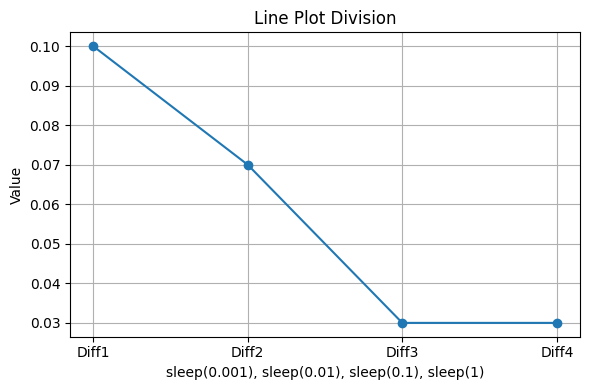

In [28]:
import matplotlib.pyplot as plt
import numpy as np

# Division von Azahl Events und Differenz
y = [0.1, 0.07, 0.03, 0.03]
x = ['Diff1', 'Diff2', 'Diff3', 'Diff4']

# Create the line plot
plt.figure(figsize=(6, 4))
plt.plot(x, y, marker='o', linestyle='-')
plt.title("Line Plot Division")
plt.xlabel("sleep(0.001), sleep(0.01), sleep(0.1), sleep(1)")
plt.ylabel("Value")
plt.grid(True)
plt.tight_layout()
plt.show()

**Resultat**
<br>Umso kleiner der Sleep Wert, umso grösser ist der "Fehler".

**Out-of-scope Sinn Thema**
<br> Eine Wartezeit von einer Sekunde macht höchstwahrscheinlich nicht Sinn, eher umgekehrt, die Reduzierung der sleep Werten.

### Quellenverzeichnis
Structured Streaming Programming Guide: https://spark.apache.org/docs/latest/structured-streaming-programming-guide.html#window-operations-on-event-time<br>

Beginning Apache Spark 3: With DataFrame, Spark SQL, Structured Streaming, and Spark Machine Learning Library:<br>6 Spark Streaming 7 Advanced Spark Streaming